**Level**: Intermediate

**Time to complete**: 20 minutes

**Prerequisites**: Prepare the Colab environment (see links below).

**Nodes Used**: InMemoryDocumentStore, MultiModalRetriever

**Goal**: After completing this tutorial, you will have learned about the MultiModalRetriever, and built a simple retrieval pipeline that searches for relevant images given a text query.

To make this pipeline work, we first need to embed the images from the dataset using a transformer model. These image embeddings are representative of respective image's content. These embeddings lie in a high dimensional vector space. Then we embed the text query using the same transformer model (i.e. OpenAI CLIP). Because we use the same transformer model, these text embeddings also exist in the same space as the image embeddings. Finally we perform nearest neighbours search to retrieve relevant images for our text query.

Let's go and build a Text-to-Image search pipeline using a small animal dataset!

## Preparing the Colab Environment

- [Enable GPU Runtime in GPU](https://docs.haystack.deepset.ai/v5.2-unstable/docs/enable-gpu-runtime-in-colab)
- [Check if GPU is Enabled](https://docs.haystack.deepset.ai/v5.2-unstable/docs/check-if-gpu-is-enabled)
- [Set logging level to INFO](https://docs.haystack.deepset.ai/v5.2-unstable/docs/set-the-logging-level)

In [ ]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab]

# Initializing the DocumentStore

A DocumentStore contains Documents, which in this case are references to the images that Haystack will compare with your query. Here we are using the InMemoryDocumentStore since it requires no external dependencies. To learn more about the DocumentStore and the different types of external databases that we support, see [DocumentStore](https://docs.haystack.deepset.ai/docs/document_store).

In [ ]:
from haystack.document_stores import InMemoryDocumentStore

document_store = InMemoryDocumentStore(embedding_dim=512)

# Downloading data

Download 18 sample images of different animals from . You can find them in data/tutorial19/spirit-animals/ as a set of .jpg files.

In [ ]:
from haystack.utils import fetch_archive_from_http

doc_dir = "data/tutorial19"

fetch_archive_from_http(
    url="https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/spirit-animals.zip",
    output_dir=doc_dir
)

Add the images you just downloaded into Haystack Document objects and write them into the DocumentStore.

In [ ]:
import os

from haystack import Document

images = [
    Document(content=f"./{doc_dir}/spirit-animals/{filename}", content_type="image")
    for filename in os.listdir(f"./{doc_dir}/spirit-animals/")
]

document_store.write_documents(images)

# Initializing the Retriever

Retrievers sift through all the images and return only those that are relevant based on the input query. Here we are using the [OpenAI CLIP model](https://github.com/openai/CLIP/blob/main/model-card.md) to embed images. For more details on supported modalities, see [MultiModalRetriever](https://docs.haystack.deepset.ai/docs/retriever#multimodal-retrieval).

In [ ]:
from haystack.nodes.retriever.multimodal import MultiModalRetriever

retriever_text_to_image = MultiModalRetriever(
    document_store=document_store,
    query_embedding_model = "sentence-transformers/clip-ViT-B-32",
    query_type="text",
    document_embedding_models = {"image": "sentence-transformers/clip-ViT-B-32"} #, "text": "sentence-transformers/clip-ViT-B-32"},
)

document_store.update_embeddings(retriever=retriever_text_to_image)

# Creating the MultiModal search Pipeline

We are populating a Pipeline with a MultiModalRetriever node. This search pipeline queries the image database with text and returns the most relevant images.

In [ ]:
from haystack import Pipeline

pipeline = Pipeline()
pipeline.add_node(
    component=retriever_text_to_image, 
    name="retriever_text_to_image", 
    inputs=["Query"]
)

# Searching Through the Images

Use the pipeline `run()` method to query the images in the DocumentStore. The query argument is where you type your text query. Additionally, you can set the number of images you want the MultiModalRetriever to return using the `top-k` parameter. To learn more about setting arguments, see [Pipeline Arguments](https://docs.haystack.deepset.ai/docs/pipelines#arguments).

In [ ]:
results = pipeline.run(
    query="Animal who lives in the water",
    params={"retriever_text_to_image": {"top_k": 3}}
)

results = sorted(results["documents"], key=lambda d: d.score, reverse=True)

for doc in results:
    print(doc.score, doc.content)

Here are some more query strings you could try out:

1.   King of the Jungle
2.   Fastest animal
3.   Bird who can see clearly even in the dark



You can also vizualize these images with their score easily with below code.




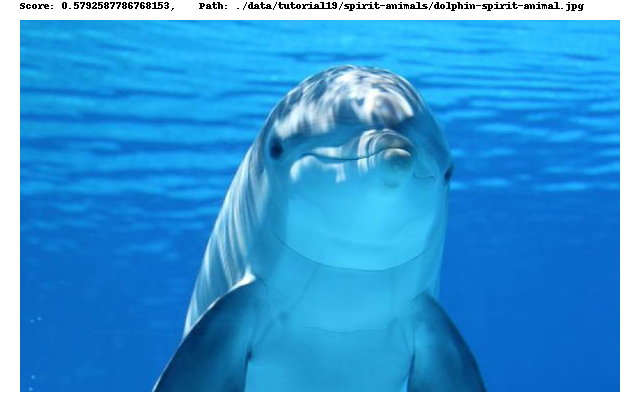

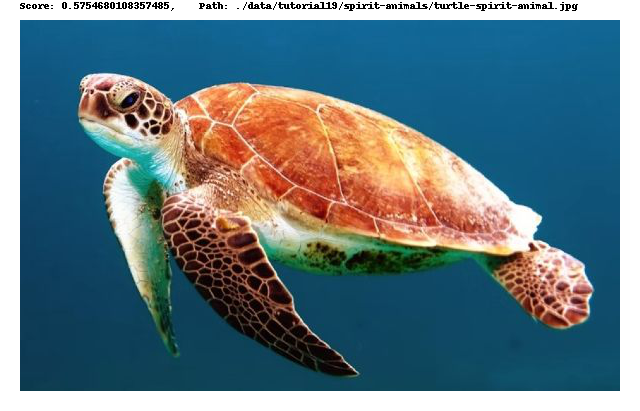

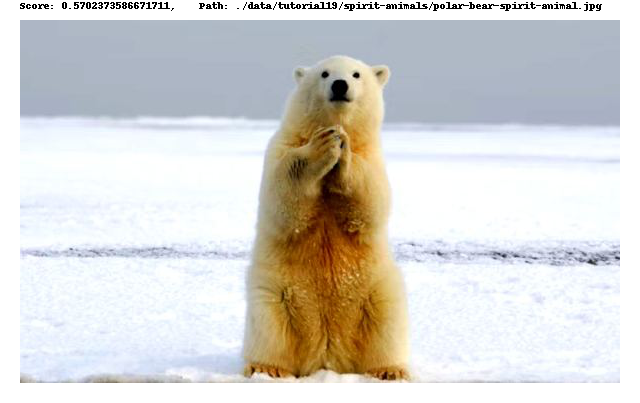

In [ ]:
from io import BytesIO
from PIL import Image, ImageDraw, ImageOps
from IPython.display import display, Image as IPImage

def display_img_array(ima, score):
    im = Image.open(ima)
    img_with_border = ImageOps.expand(im ,border=20, fill='white')

    # Add Text to an image
    img = ImageDraw.Draw(img_with_border)
    img.text((20, 0), f"Score: {score},    Path: {ima}", fill=(0, 0, 0))

    bio = BytesIO()
    img_with_border.save(bio, format='png')
    display(IPImage(bio.getvalue(), format='png'))

images_array = [doc.content for doc in results]
scores = [doc.score for doc in results]
for ima, score in zip(images_array, scores):
    display_img_array(ima, score)

## About us

This [Haystack](https://github.com/deepset-ai/haystack/) notebook was made with love by [deepset](https://deepset.ai/) in Berlin, Germany

We bring NLP to the industry via open source!  
Our focus: Industry specific language models & large scale QA systems.  
  
Some of our other work: 
- [German BERT](https://deepset.ai/german-bert)
- [GermanQuAD and GermanDPR](https://deepset.ai/germanquad)

Get in touch:
[Twitter](https://twitter.com/deepset_ai) | [LinkedIn](https://www.linkedin.com/company/deepset-ai/) | [Discord](https://haystack.deepset.ai/community/join) | [GitHub Discussions](https://github.com/deepset-ai/haystack/discussions) | [Website](https://deepset.ai)

By the way: [we're hiring!](https://www.deepset.ai/jobs)